In [81]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [4]:
N = 100
num_groups = 3
num_values_per_group = 40
p_missing = 0.2

Ds = []
for k in range(num_groups):
    d = np.ones((N, num_values_per_group)) * (k + 1) * 10
    Ds.append(d)

In [12]:
D = np.hstack(Ds)
print(D)

[[10. 10. 10. ... 30. 30. 30.]
 [10. 10. 10. ... 30. 30. 30.]
 [10. 10. 10. ... 30. 30. 30.]
 ...
 [10. 10. 10. ... 30. 30. 30.]
 [10. 10. 10. ... 30. 30. 30.]
 [10. 10. 10. ... 30. 30. 30.]]


In [13]:
n1, n2 = D.shape
S = np.random.rand(n1,n2)
D[S < 0.2] = 0

In [20]:
D_img = Image.fromarray(D.astype(np.uint8))

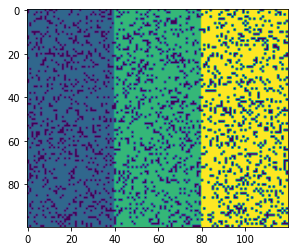

In [21]:
plt.imshow(D_img)

In [15]:
rpca = R_pca(D)
L, S = rpca.fit(max_iter=10000, iter_print=100)

iteration: 1, error: 6.587292365844637
iteration: 100, error: 0.11223748871007752
iteration: 200, error: 0.027946099969143594
iteration: 300, error: 0.04053759391108532
iteration: 400, error: 0.028423600912342886
iteration: 500, error: 0.052028160744179236
iteration: 600, error: 0.10913198142306385
iteration: 700, error: 0.005648856198642618
iteration: 768, error: 0.00020322208910811447


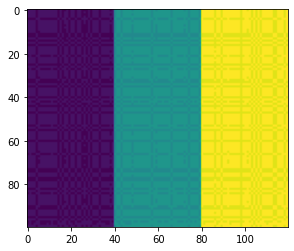

In [24]:
L_img = Image.fromarray(L.astype(np.uint8))
plt.imshow(L_img)

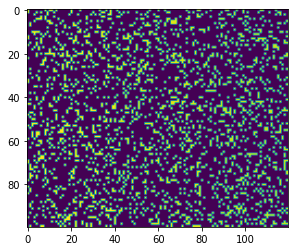

In [25]:
S_img = Image.fromarray(S.astype(np.uint8))
plt.imshow(S_img)

ymin: 0.0, ymax: 30.0


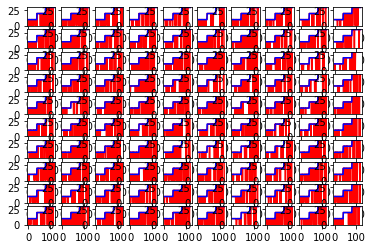

In [26]:
rpca.plot_fit()

In [77]:
from __future__ import division, print_function

import numpy as np

try:
    from pylab import plt
except ImportError:
    print('Unable to import pylab. R_pca.plot_fit() will not work.')

try:
    # Python 2: 'xrange' is the iterative version
    range = xrange
except NameError:
    # Python 3: 'range' is iterative - no need for 'xrange'
    pass


class R_pca:

    def __init__(self, D, mu=None, lmbda=None):
        self.D = D
        self.S = np.zeros(self.D.shape)
        self.Y = np.zeros(self.D.shape)

        if mu:
            self.mu = mu
        else:
            self.mu = np.prod(self.D.shape) / (4 * np.linalg.norm(self.D, ord=1))

        self.mu_inv = 1 / self.mu

        if lmbda:
            self.lmbda = lmbda
        else:
            self.lmbda = 1 / np.sqrt(np.max(self.D.shape))

    @staticmethod
    def frobenius_norm(M):
        return np.linalg.norm(M, ord='fro')

    @staticmethod
    def shrink(M, tau):
        return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

    def svd_threshold(self, M, tau):
        U, S, V = np.linalg.svd(M, full_matrices=False)
        return np.dot(U, np.dot(np.diag(self.shrink(S, tau)), V))

    def fit(self, tol=None, max_iter=1000, iter_print=100):
        iter = 0
        err = np.Inf
        Sk = self.S
        Yk = self.Y
        Lk = np.zeros(self.D.shape)

        if tol:
            _tol = tol
        else:
            _tol = 1E-7 * self.frobenius_norm(self.D)

        #this loop implements the principal component pursuit (PCP) algorithm
        #located in the table on page 29 of https://arxiv.org/pdf/0912.3599.pdf
        while (err > _tol) and iter < max_iter:
            Lk = self.svd_threshold(
                self.D - Sk + self.mu_inv * Yk, self.mu_inv)                            #this line implements step 3
            Sk = self.shrink(
                self.D - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)             #this line implements step 4
            Yk = Yk + self.mu * (self.D - Lk - Sk)                                      #this line implements step 5
            err = self.frobenius_norm(self.D - Lk - Sk)
            iter += 1
            if (iter % iter_print) == 0 or iter == 1 or iter > max_iter or err <= _tol:
                print('iteration: {0}, error: {1}'.format(iter, err))

        self.L = Lk
        self.S = Sk
        return Lk, Sk

    def plot_fit(self, size=None, tol=0.1, axis_on=True):

        n, d = self.D.shape

        if size:
            nrows, ncols = size
        else:
            sq = np.ceil(np.sqrt(n))
            nrows = int(sq)
            ncols = int(sq)

        ymin = np.nanmin(self.D)
        ymax = np.nanmax(self.D)
        print('ymin: {0}, ymax: {1}'.format(ymin, ymax))

        numplots = np.min([n, nrows * ncols])
        plt.figure()

        for n in range(numplots):
            plt.subplot(nrows, ncols, n + 1)
            plt.ylim((ymin - tol, ymax + tol))
            plt.plot(self.L[n, :] + self.S[n, :], 'r')
            plt.plot(self.L[n, :], 'b')
            if not axis_on:
                plt.axis('off')

(200, 300, 3)


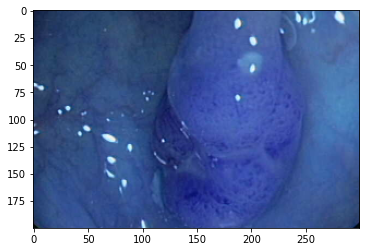

In [82]:
img = cv2.imread('./images/113.bmp')
img = img[50:250, 50:350]
print(img.shape)
plt.imshow(img)

In [88]:
im = Image.open('./images/113.bmp')
im_array = np.array(im)

In [89]:
rpca = R_pca(img)
L_high, S_high = rpca.fit(max_iter=10000, iter_print=100)

ValueError: Improper number of dimensions to norm.

NameError: name 'L_res' is not defined

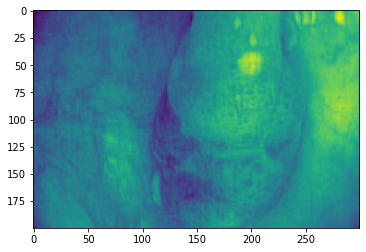

In [87]:
plt.imshow(L_high)
# L_res = cv2.cvtColor(L_high, cv2.COLOR_GRAY2RGB)
plt.imshow(L_res)

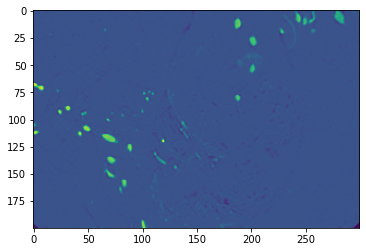

In [91]:
plt.imshow(S_high)

In [94]:
import numpy as np
from scipy.sparse.linalg import svds
from scipy.linalg import svd
from scipy.linalg import qr
from numpy.linalg import norm
import matplotlib.pyplot as plt


def wthresh(A, thresh):
    '''Port of matlabs hard thresholding wthresh.
    see: https://www.mathworks.com/help/wavelet/ref/wthresh.html
    Args:
        A (array): array on which to apply the thresholding.
        threshold (float): threshold value.
    Returns:
        array: thresholded array.
    '''
    out = A.copy()
    out[np.abs(out)<thresh] = 0
    return out


class RobustPCA:
    def __init__(self, n_components=None, max_iter=100, tol=1e-5, beta=None, beta_init=None, gamma=0.5, mu=[5, 5], trim=False, verbose=True, copy=True):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.beta = beta
        self.beta_init = beta_init
        self.gamma = gamma
        self.mu = mu
        self.trim = trim
        self.verbose = verbose
        self.copy = copy

    def fit(self, X, y=None):
        self._fit(X)
        return self

    def _initialisation(self, X): 

        n_samples, n_features = X.shape
        if self.beta is None:
            beta = 1/(2 * np.power(n_samples*n_features, 1/4));
        else:
            beta = self.beta
        if self.beta_init is None:
            beta_init = 4 * beta
        else:
            beta_init = self.beta_init
        if self.n_components is None:
            n_components = min(X.shape) - 1
        else:
            n_components = self.n_components

        zeta = beta_init * svds(X, k=1, return_singular_vectors=False)[0]
        S = wthresh(X, zeta)
        U, Sigma, V = svds(X - S, n_components)
        # transpose the V for consistency with matlab
        V = V.T
        # make Sigma a diag for consistency with matlab implementation
        Sigma = np.diag(Sigma)
        L = U @ Sigma @ V.T
        zeta = beta * Sigma[0, 0]
        S = wthresh(X - L ,zeta)

        self.beta_ = beta
        self.beta_init_ = beta_init
        self.n_samples_ = n_samples
        self.n_features_ = n_features
        self.n_components_ = n_components
        return L, S, U, Sigma, V

    def _fit(self, X):
        if self.copy:
            X = np.copy(X)

        errors = []
        norm_of_X = norm(X, 'fro')


        self.mean_ = np.mean(X, axis=0)
        X -= self.mean_

        L, S, U, Sigma, V = self._initialisation(X)
        errors.append(norm(X - L - S, 'fro') / norm_of_X)

        for i in range(1, self.max_iter + 1):
            if self.trim:
                U, V = self._trim(U, Sigma[:self.n_components_, :self.n_components_], V, self.mu[0], self.mu[-1])
            # update L
            Z = X - S
            # print('Z', Z.shape)
            # print('V', V.shape)
            # print(Z @ V)
            # These 2 QR can be computed in parallel
            Q1, R1 = qr(Z.T @ U - V @ ((Z @ V).T @ U), mode='economic')
            Q2, R2 = qr(Z @ V - U @ (U.T @ Z  @ V), mode='economic')
            # print('R1', R1.shape)
            # print('R2', R2.shape)
            # print('upper_left', (U.T @ Z @ V).shape)

            M = np.vstack([np.hstack([U.T @ Z @ V, R1.T]),
                           np.hstack([R2, np.zeros_like(R2)])])
            # print('M', M.shape)
            U_of_M, Sigma, V_of_M = svd(M, full_matrices=False)
            V_of_M = V_of_M.T
            Sigma = np.diag(Sigma)
            # These 2 matrices multiplications can be computed in parallel
            U = np.hstack([U, Q2]) @ U_of_M[:, :self.n_components_]
            V = np.hstack([V, Q1]) @ V_of_M[:, :self.n_components_]
            L = U @ Sigma[:self.n_components_, :self.n_components_] @ V.T

            # update S
            zeta = self.beta_ * (Sigma[self.n_components_, self.n_components_] + ((self.gamma**i) * Sigma[0, 0]))
            S = wthresh(X - L, zeta)

            errors.append(norm(X - L - S, 'fro') / norm_of_X)

            if self.verbose:
                print(f'[{i}] Tolerance: {self.tol}\tCurrent error: {errors[i]}')
            if errors[i] < self.tol:
                print('Tolerance condition met.')
                break
        else:
            print('Tolerance condition not met.')
        self.L_ = L
        self.S_ = S
        self.U_ = U
        self.V_ = V
        self.Sigma_ = Sigma

        self.low_rank_ = L
        self.sparse_ = S
        # transpose V for consistency with sklearn's pca
        self.components_ = V.T
        # flatten the Sigma for  consistency with sklearn's pca
        self.singular_values_ = np.diag(Sigma)[:self.n_components_]

        self.end_iter_ = i
        self.errors_ = errors
        return L, S, U, Sigma, V

    def transform(self, X):
        if self.copy:
            X = np.copy(X)
        if self.mean_ is not None:
            X -= self.mean_
        return X @ self.components_.T

    def inverse_transform(self, X):
        return (X @ self.components_) + self.mean_  

    def fit_transform(self, X, y=None):
        _, _, U, Sigma, _ = self._fit(X)
        U = U[:, :self.n_components_]
        U *= np.diag(Sigma)[:self.n_components_]
        return U

    @staticmethod
    def __trim(X, mu_X):
        m, r = X.shape
        row_norm_square_X = np.sum(np.power(X, 2), axis=1)  # might need to set it to columns vector
        big_rows_X = row_norm_square_X > (mu_X * r / m)
        X[big_rows_X] = X[big_rows_X] * ((mu_X * r / m) / np.sqrt(row_norm_square_X[big_rows_X]))[:, np.newaxis]
        Q, R = qr(X, mode='economic')
        return Q, R

    def _trim(self, U, Sig, V , mu_V, mu_U):
        # these 2 qr can be computed in parallel
        Q1, R1 = self.__trim(U, mu_U)
        Q2, R2 = self.__trim(V, mu_V)
        U_tmp, _, V_tmp = svd(R1 @ Sig @ R2.T, full_matrices=False)
        return Q1 @ U_tmp, Q2 @ V_tmp.T